In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"   # Force CUDA to be synchronous

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

from tqdm.notebook import tqdm
import re
from datasets import Dataset

## 1. Data Loading and Initial Exploration

In this section, we load the training dataset and perform an initial exploratory analysis:  
- Check the shape and structure of the data  
- View several sample rows  
- Visualize class and year distributions  
- Calculate the average and median length of texts


In [2]:
DATASET = pd.read_csv("train.csv")

In [3]:
df = DATASET

print("Number of samples:", len(df))
print("Columns:", df.columns.tolist())
print("Number of unique classes:", df['class'].nunique())
print("Years in the dataset:", sorted(df['year'].unique()))

display(df.sample(10))


Number of samples: 216974
Columns: ['id', 'text', 'class', 'year']
Number of unique classes: 21
Years in the dataset: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


,id,text,class,year
203702,203702,Aprovació inicial del projecte de reparcel·lac...,17,2020
184334,184334,Aprovació inicial del Pla estratègic de subven...,3,2019
173487,173487,Aprovació definitiva del pressupost general de...,12,2018
214021,214021,Aprovació provisional dels expedients modifica...,12,2020
69324,69324,Aprovació definitiva del Projecte de construcc...,0,2014
163647,163647,Convocatòria d'ajuts per activitats d'estiu.,15,2018
121377,121377,Licitació per al subministrament i manteniment...,0,2016
114672,114672,Aprovació inicial de la modificació de crèdit ...,12,2016
176019,176019,Licitació del contracte relatiu a la implantac...,0,2019
120122,120122,Licitació del contracte privat d'assegurances ...,4,2016


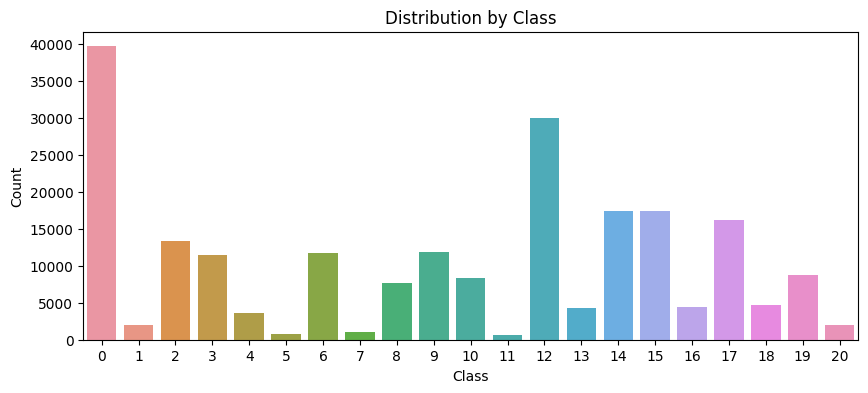

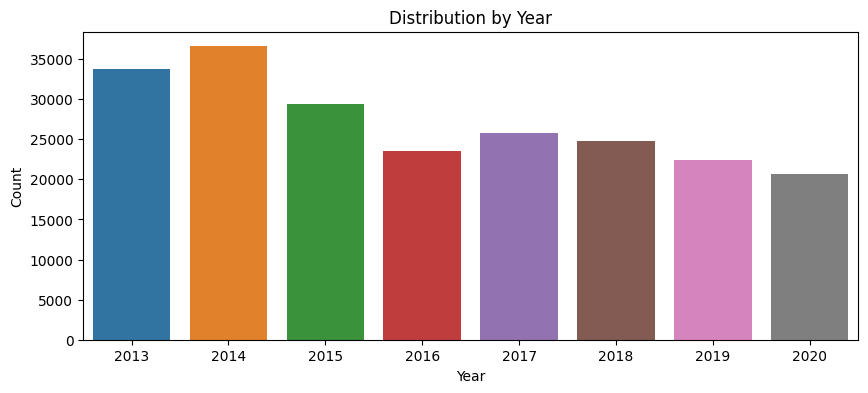

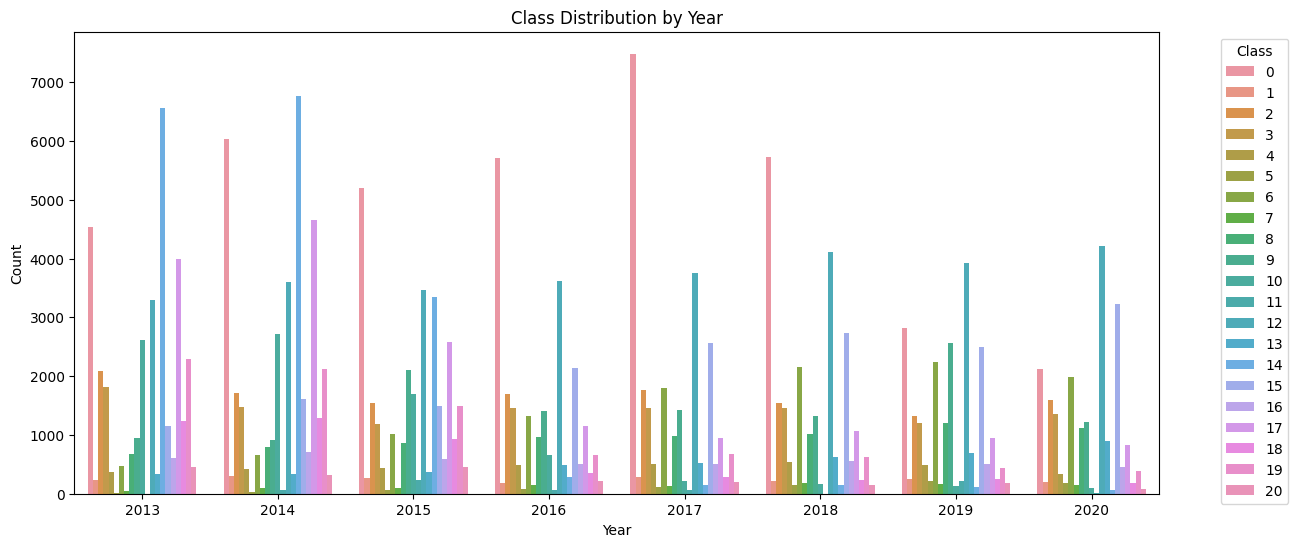

In [4]:
# Distribution of samples across classes to identify any class imbalance, which can affect training and evaluation.
plt.figure(figsize=(10,4))
sns.countplot(x='class', data=df)
plt.title('Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Distribution of samples by year to check for temporal patterns or data skews that may influence model generalization.
plt.figure(figsize=(10,4))
sns.countplot(x='year', data=df)
plt.title('Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Distribution of classes within each year
plt.figure(figsize=(14,6))
sns.countplot(x='year', hue='class', data=df)
plt.title('Class Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [5]:
# Compute the length of each text in characters; this helps in understanding text size variability and guides preprocessing (e.g., max sequence length for BERT).
df['text_len_chars'] = df['text'].str.len()

# Compute the length of each text in words to get additional statistics about text complexity and to compare with character-based length.
df['text_len_words'] = df['text'].str.split().apply(len)

# Output average and median values to summarize dataset and support decisions on padding/truncation for modeling.
print("Average text length (characters):", df['text_len_chars'].mean())
print("Median text length (characters):", df['text_len_chars'].median())
print("Average text length (words):", df['text_len_words'].mean())
print("Median text length (words):", df['text_len_words'].median())


Average text length (characters): 99.16521334353425
Median text length (characters): 94.0
Average text length (words): 14.576990791523409
Median text length (words): 14.0


### Summary of Data Exploration

- The dataset shows a strong class imbalance:
  - Classes 0 and 12 are much more frequent than others.
  - Several classes (such as 5, 7, 13, 15, and 20) have very few samples, which may lead to poor generalization for these classes.
- The average text is short (~99 characters or ~14 words).
- Year distribution is skewed toward earlier years (2013–2014).

**To mitigate the impact of class imbalance, we will:**
- Use stratified train/validation split to preserve class proportions during training and evaluation.
- Monitor not only overall accuracy but also macro-F1 and the confusion matrix to assess performance across all classes, including minority ones.
- Consider implementing class weights in the loss function if we observe poor recognition of rare classes during validation.


## 2. Text Cleaning and Basic Preprocessing

In this section:
- Convert all texts to lowercase.
- Remove special characters, keeping only letters, numbers, and spaces.
- Stopwords (including Catalan function words) are intentionally preserved, as transformer-based models benefit from full sentence structure.
- Analyze how text cleaning affects text length and update statistics.

In [6]:
def clean_text(text):
    # Convert all characters to lowercase for normalization and to reduce vocabulary size for the model.
    text = text.lower()
    # Remove all characters except letters (including accented), digits, and spaces to standardize input for tokenization.
    text = re.sub(r'[^a-zà-ÿ0-9\s]', '', text)
    # Replace multiple consecutive spaces with a single space and trim edges to avoid artificial token inflation.
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
df['clean_text'] = df['text'].apply(clean_text)

### Analyze the Effect of Text Cleaning

Compare average and median lengths of original and cleaned texts to understand the impact of preprocessing.


In [8]:
# Recalculate character and word lengths after cleaning to check if cleaning significantly shortens the text or changes its structure.
df['clean_len_chars'] = df['clean_text'].str.len()
df['clean_len_words'] = df['clean_text'].str.split().apply(len)

# Print updated statistics to support decisions about input sequence length for the model.
print("Average cleaned text length (characters):", df['clean_len_chars'].mean())
print("Median cleaned text length (characters):", df['clean_len_chars'].median())
print("Average cleaned text length (words):", df['clean_len_words'].mean())
print("Median cleaned text length (words):", df['clean_len_words'].median())

Average cleaned text length (characters): 96.20189515794519
Median cleaned text length (characters): 92.0
Average cleaned text length (words): 14.565832772590264
Median cleaned text length (words): 14.0


### Conclusion

No significant changes in text length after cleaning.


## 3. Train/Validation Split

We perform a stratified split to preserve class proportions in both the training and validation sets, which helps mitigate class imbalance during model training and evaluation.


In [9]:
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['class'], 
    random_state=2025
)

# Rename target column to 'labels' for Trainer compatibility
train_df = train_df.rename(columns={"class": "labels"})
val_df   = val_df.rename(columns={"class": "labels"})

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

Training samples: 173579
Validation samples: 43395


## 4. Tokenization and Preparation for Training

- Select a BERT model en catalan
- Load the tokenizer using AutoTokenizer.
- Tokenize the texts and prepare PyTorch datasets for the Trainer.


In [10]:
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

# Load the pretrained BERT tokenizer to convert texts into input IDs and attention masks.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_length = 64  # Cover occasional longer texts and better leverage available GPU memory

def tokenize_batch(batch):
    # Tokenize texts, truncating or padding to a fixed max_length for batch processing.
    return tokenizer(
        batch["clean_text"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_length
    )

# Prepare data for HuggingFace Trainer by converting DataFrame to Dataset.
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenization to the datasets.
train_dataset = train_dataset.map(tokenize_batch, batched=True)
val_dataset = val_dataset.map(tokenize_batch, batched=True)


Map:   0%|          | 0/173579 [00:00<?, ? examples/s]

Map:   0%|          | 0/43395 [00:00<?, ? examples/s]

## 5. Model Building and Training

- Load the RoBERTa-base Catalan model (`PlanTL-GOB-ES/roberta-base-ca`) for sequence classification (21 output classes).
- Define training parameters with TrainingArguments.
- Train the model using Huggingface Trainer.
- Save the best model checkpoint based on validation accuracy.


In [11]:
# Use the Catalan RoBERTa-base model for sequence classification
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=21)

training_args = TrainingArguments(
    output_dir='./roberta-ca-results-strats',

    eval_strategy="epoch", 
    save_strategy="epoch",    

    save_total_limit=1,

    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=3,

    learning_rate=4e-5,
    warmup_steps=500,

    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,

    logging_dir='./logs',
    logging_steps=100,
    report_to="tensorboard",

    seed=42,
    fp16=True,
    max_grad_norm=1.0
)




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')       # Average F1 score across classes
    precision_macro = precision_score(labels, preds, average='macro')  # Average precision across classes
    recall_macro = recall_score(labels, preds, average='macro')        # Average recall across classes
    
    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("./best_roberta_ca_model_strats")

# After training, get predictions on validation set for detailed analysis
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

print("Classification Report:")
print(classification_report(labels, preds))

print("Confusion Matrix:")
print(confusion_matrix(labels, preds))



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.142300,0.136640,0.963590,0.952347,0.954745,0.951039
2,0.101800,0.114322,0.968199,0.959913,0.961267,0.958736
3,0.074900,0.111748,0.969167,0.961031,0.961508,0.960662


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7924
           1       0.99      1.00      0.99       387
           2       0.99      0.99      0.99      2655
           3       0.96      0.95      0.96      2286
           4       0.86      0.84      0.85       717
           5       0.96      0.97      0.96       168
           6       0.99      0.99      0.99      2330
           7       0.95      0.97      0.96       200
           8       0.98      0.96      0.97      1528
           9       0.94      0.98      0.96      2376
          10       1.00      1.00      1.00      1660
          11       0.99      0.99      0.99       134
          12       0.99      0.99      0.99      5995
          13       0.99      0.99      0.99       852
          14       0.97      0.97      0.97      3484
          15       0.98      0.99      0.98      3481
          16       0.97      0.95      0.96       885
    

## 6. Temporal Split: Training on Early Years and Testing on Recent Years

Based on the distribution of samples across years, we observe that the majority of data is concentrated between 2013 and 2017, with a decreasing number of samples in later years (2018–2020). To better simulate real-world model performance and evaluate its generalization to new data, we split the dataset temporally:

- **Training set:** samples from years 2013 to 2017 (inclusive).  
- **Test set:** samples from years 2018 onwards.

This approach allows us to train the model on historical data and evaluate accuracy on more recent, potentially shifted data distributions.

In [13]:
train_years = list(range(2013, 2018))
train_df = df[df['year'].isin(train_years)].copy()
val_df = df[~df['year'].isin(train_years)].copy()

# Rename target column to 'labels' for Trainer compatibility
train_df = train_df.rename(columns={"class": "labels"})
val_df   = val_df.rename(columns={"class": "labels"})

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

Training samples: 149173
Validation samples: 67801


## 7. Tokenization and Preparation for Training for another step

- Select a BERT model en catalan
- Load the tokenizer using AutoTokenizer.
- Tokenize the texts and prepare PyTorch datasets for the Trainer.

In [14]:
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

# Load the pretrained BERT tokenizer to convert texts into input IDs and attention masks.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_length = 64  # Cover occasional longer texts and better leverage available GPU memory

def tokenize_batch(batch):
    # Tokenize texts, truncating or padding to a fixed max_length for batch processing.
    return tokenizer(
        batch["clean_text"], 
        padding="max_length", 
        truncation=True, 
        max_length=max_length
    )

# Prepare data for HuggingFace Trainer by converting DataFrame to Dataset.
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenization to the datasets.
train_dataset = train_dataset.map(tokenize_batch, batched=True)
val_dataset = val_dataset.map(tokenize_batch, batched=True)


Map:   0%|          | 0/149173 [00:00<?, ? examples/s]

Map:   0%|          | 0/67801 [00:00<?, ? examples/s]

## 8. Model Building and Training

- Load the RoBERTa-base Catalan model (`PlanTL-GOB-ES/roberta-base-ca`) for sequence classification (21 output classes).
- Define training parameters with TrainingArguments.
- Train the model using Huggingface Trainer.
- Save the best model checkpoint based on validation accuracy.

In [15]:
# Use the Catalan RoBERTa-base model for sequence classification
model_checkpoint = "PlanTL-GOB-ES/roberta-base-ca"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=21)

training_args = TrainingArguments(
    output_dir='./roberta-ca-results-years',

    eval_strategy="epoch", 
    save_strategy="epoch",    

    save_total_limit=1,

    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=3,

    learning_rate=4e-5,
    warmup_steps=500,

    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,

    logging_dir='./logs',
    logging_steps=100,
    report_to="tensorboard",

    seed=42,
    fp16=True,
    max_grad_norm=1.0
)




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')       # Average F1 score across classes
    precision_macro = precision_score(labels, preds, average='macro')  # Average precision across classes
    recall_macro = recall_score(labels, preds, average='macro')        # Average recall across classes
    
    return {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("./best_roberta_ca_model_years")

# After training, get predictions on validation set for detailed analysis
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

print("Classification Report:")
print(classification_report(labels, preds))

print("Confusion Matrix:")
print(confusion_matrix(labels, preds))



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,0.131500,0.176212,0.954204,0.922537,0.923890,0.926687
2,0.091800,0.168681,0.958363,0.929254,0.929727,0.931674
3,0.071700,0.178263,0.957464,0.927417,0.930587,0.927157


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     10657
           1       0.99      0.99      0.99       657
           2       0.97      0.98      0.98      4466
           3       0.94      0.91      0.93      4034
           4       0.91      0.68      0.78      1372
           5       0.98      0.96      0.97       547
           6       0.99      0.99      0.99      6376
           7       0.96      0.96      0.96       489
           8       0.97      0.96      0.96      3348
           9       0.95      0.94      0.94      5104
          10       0.99      0.98      0.99       395
          11       0.98      1.00      0.99       239
          12       0.99      0.99      0.99     12251
          13       0.99      0.98      0.99      2209
          14       0.77      0.86      0.82       327
          15       0.98      0.99      0.98      8455
          16       0.92      0.96      0.94      1503
    